# 实验 v1.3

## 实验基本环境设置

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt

In [2]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

## 自定义函数

In [3]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult import X_train, y_train, X_test, y_test, sex, feature_index # 获得 数据集 测试集 和 测试集上的敏感属性


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 超参设置

In [4]:
# 
seed = 1
np.random.seed(seed)

percent_k = 0.15
top_k = int(len(X_train) * percent_k)
"选取的样本数量是", top_k

('选取的样本数量是', 3418)

## 模型：逻辑回归

In [5]:
# 逻辑回归 - 训练
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
# 逻辑回归 - 预测
y_pred = logreg.predict(X_test)
# 逻辑回归 - 指标
res_origin = fairness_metrics(y_test, y_pred, sex)

In [6]:
from sklearn.linear_model import ARDRegression

ard_origin, res_ard = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    test_func=test_model,
    sensitive_feature=sex,
    model_cls=ARDRegression,
    desc="ard测试组",
)

## XGBoost 原始数据

In [8]:
import xgboost


xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)

## XGBoost 优化组 + 对照组

In [9]:
(X_train_top, y_train_top), (X_train_rand, y_train_rand) = get_ext_train_comp_by_k(
    xgboost_origin, X_train, y_train, feature_index, top_k
)

In [10]:
xgboost_top, res_top = train_model_and_test(
    X_train_top,
    y_train_top,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="优化组",
)

In [11]:
xgboost_rand, res_rand = train_model_and_test(
    X_train_rand,
    y_train_rand,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="对照组",
)

## 数据分析

In [12]:
df = pd.DataFrame([res_origin, res_top, res_rand],index=["origin", "top-k", "rand-k"])
df

,准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,0.862422,0.768377,0.615939,0.059109,0.384061,0.683765,0.169896,0.322507,0.087648,0.295970
top-k,0.860886,0.761506,0.617211,0.061538,0.382789,0.681808,0.171762,0.322571,0.089149,0.296363
rand-k,0.861091,0.761482,0.618482,0.061673,0.381518,0.682573,0.167337,0.337199,0.061147,0.305172


## 画图

adult-xgboost-shap-k=3418(15.0%)

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

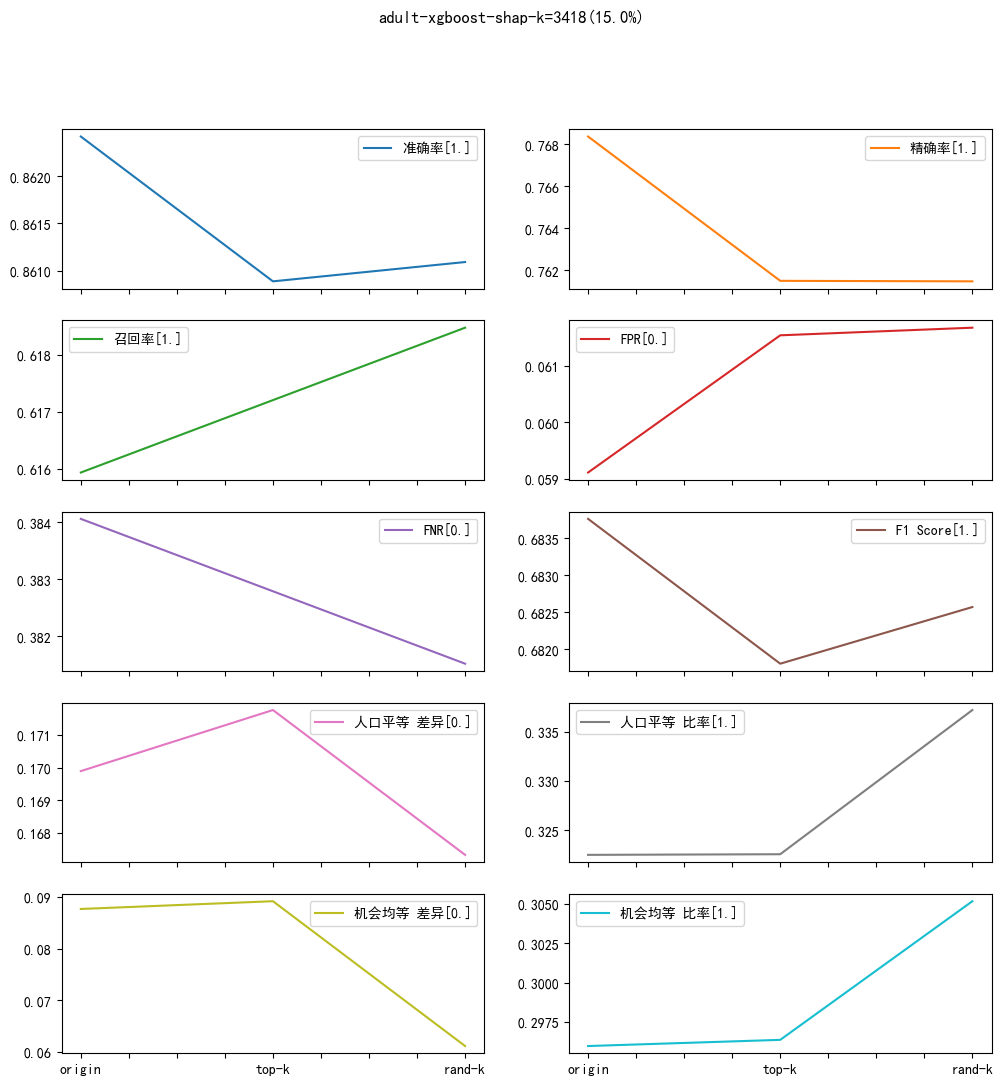

In [13]:
title = f"adult-xgboost-shap-k={top_k}({percent_k*100}%)"
print(title)
df.plot(
    title=title,
    subplots=True, 
    layout=(5, 2), 
    figsize=(12, 12), 
    kind='line',
)